In [ ]:
# Load all necessary Packages
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# supporting libraries
import numpy as np
import time
import os
import copy
import pickle
import h5py

# For plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
# Load Dataset
# Training samples
pickle_in = open("/gdrive/My Drive/TOCR_CNN/X_40.pickle","rb")
X = pickle.load(pickle_in)
X = X/255.0

#Ground Truth
pickle_in = open("/gdrive/My Drive/TOCR_CNN/y_40.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y).reshape(len(y),1)

In [ ]:
#Split the Data
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

inputdim = x_train.shape[1:]

(43476, 40, 40, 1) (10870, 40, 40, 1) (43476, 1) (10870, 1)


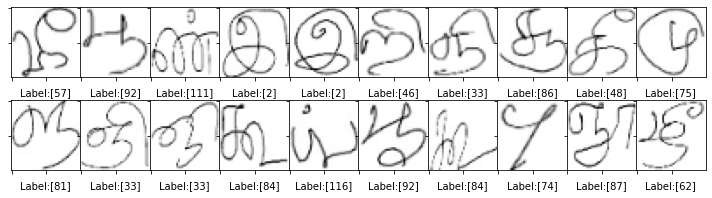

In [ ]:
#display a few sample outputs
# Create a figure
fig,ax = plt.subplots(nrows=2,ncols=10,figsize=(10,3),gridspec_kw = {'wspace':0, 'hspace':0})
indices = np.random.randint(0,1000,25)
ind = 0
for i,ax in enumerate(fig.axes):   
    ax.imshow(x_train[ind,:,:,0], cmap='gray')
    ax.set_xlabel('Label:{0}'.format(y_train[ind]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ind += 1
fig.tight_layout()

In [ ]:
Y_train = to_categorical(y_train) # one hot encoded
Y_test = to_categorical(y_test) # one hot encoded
# The dimention of a sample and the label
dim = X.shape
print('No.of samples:{0},Channel:{1},Width:{2},Hight:{3}'.format(dim[0],dim[1],dim[2],dim[3]))
print('The Ground truth',y_train.shape)
print('One hot encoded: ',Y_train.shape)


No.of samples:54346,Channel:40,Width:40,Hight:1
The Ground truth (43476, 1)
One hot encoded:  (43476, 124)


In [ ]:
NAME = "TAMIL_handwritten_CHARACTER_RECOGNITION_15_epoch_conv_3_30p"
initializer = initializers.he_uniform(seed = 10)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=inputdim, padding='valid',kernel_initializer=initializer))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(rate = 0.3))
model.add(Conv2D(64, (3, 3), padding='valid',kernel_initializer=initializer))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(rate = 0.3))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(2048,activation ='relu',kernel_initializer=initializer))
model.add(Dense(124,activation ='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 38, 38, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.fit(x_train,Y_train, batch_size=128, epochs=50, callbacks = [tensorboard],validation_split=0.15)

Epoch 1/50
  1/289 [..............................] - ETA: 0s - loss: 7.6594 - accuracy: 0.0156WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
289/289 [==============================] - 124s 431ms/step - loss: 4.5119 - accuracy: 0.0898 - val_loss: 2.5922 - val_accuracy: 0.3937
Epoch 2/50
289/289 [==============================] - 124s 430ms/step - loss: 1.9377 - accuracy: 0.4843 - val_loss: 1.5677 - val_accuracy: 0.5984
Epoch 3/50
289/289 [==============================] - 124s 429ms/step - loss: 1.1434 - accuracy: 0.6744 - val_loss: 1.1144 - val_accuracy: 0.7039
Epoch 4/50
289/289 [==============================] - 124s 430ms/step - loss: 0.7590 - accuracy: 0.7766 - val_loss: 0.7370 - val_accuracy: 0.8008
Epoch 5/50
289/289 [==============================] - 

In [ ]:
model.save("oct_tamil_model_50.h5")

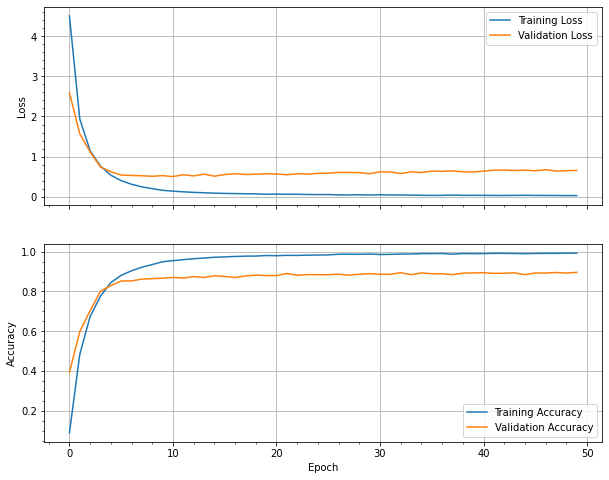

In [ ]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8))
ax[0].plot(model.history.history['loss'],label='Training Loss')
ax[0].plot(model.history.history['val_loss'],label='Validation Loss')
ax[1].plot(model.history.history['accuracy'],label='Training Accuracy')
ax[1].plot(model.history.history['val_accuracy'],label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[0].annotate('')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].grid()
ax[1].grid()

In [ ]:
# Test Accuracy
score = model.evaluate(x_test,Y_test,callbacks=tensorboard)
print('Loss:{0}, Accuracy:{1}'.format(score[0],score[1]))

340/340 [==============================] - 10s 29ms/step - loss: 0.7288 - accuracy: 0.8890
Loss:0.7287868857383728, Accuracy:0.8889604210853577


In [ ]:
#prediction
predicted = model.predict(x_test)
mat = confusion_matrix(y_test,np.argmax(predicted,axis=-1) )

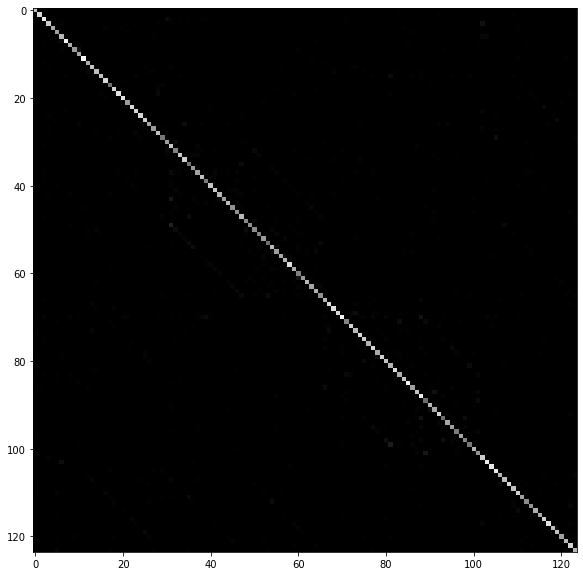

In [ ]:
Mat = mat/np.max(mat)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(mat, cmap='gray')

Text(0.5, 1.0, 'On Test Set')

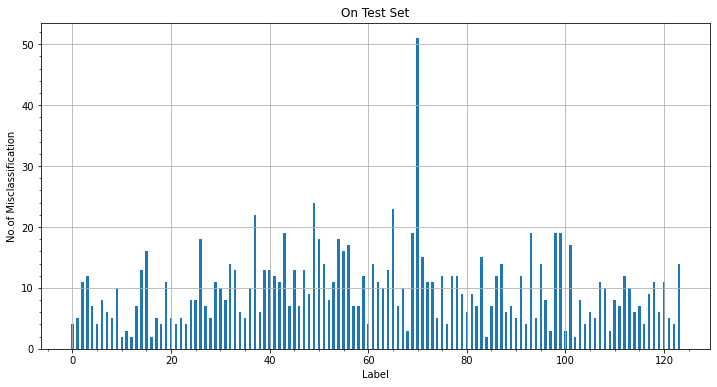

In [ ]:
# Have to fix it
diag = np.diag(mat)
n = np.arange(0,len(diag))
class_count, bin = np.histogram(y_test,bins=124,range=(0,124)) 
misclas = class_count - diag
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(n,misclas,width=0.5)
ax.grid(True)
ax.minorticks_on()
ax.set_xlabel('Label')
ax.set_ylabel('No.of Misclassification')
ax.set_title('On Test Set')

In [ ]:
print('Highly misclassified class: ',np.argmax(misclas))
print('Top 5 misclassification: ',np.argsort(misclas)[-1:-6:-1])

Highly misclassified class:  70
Top 5 misclassification:  [70 49 65 37 69]


In [ ]:
# Train Accuracy
score = model.evaluate(x_train,Y_train)
print('Loss:{0}, Accuracy:{1}'.format(score[0],score[1]))
predicted = model.predict(x_train)
mat = confusion_matrix(y_train,np.argmax(predicted,axis=-1) )
diag = np.diag(mat)
n = np.arange(0,len(diag))
class_count, bin = np.histogram(y_train,bins=124,range=(0,124)) 
misclas = class_count - diag

1359/1359 [==============================] - 38s 28ms/step - loss: 0.1008 - accuracy: 0.9838
Loss:0.10080517828464508, Accuracy:0.9838071465492249


Text(0.5, 1.0, 'On Training Set')

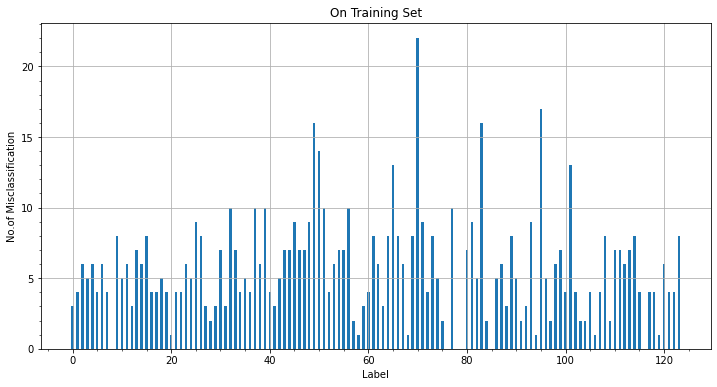

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(n,misclas,width=0.5)
ax.grid(True)
ax.minorticks_on()
ax.set_xlabel('Label')
ax.set_ylabel('No.of Misclassification')
ax.set_title('On Training Set')

In [ ]:
print('Highly misclassified class: ',np.argmax(misclas))
print('Top 5 misclassification: ',np.argsort(misclas)[-1:-6:-1])

Highly misclassified class:  70
Top 5 misclassification:  [70 95 83 49 50]


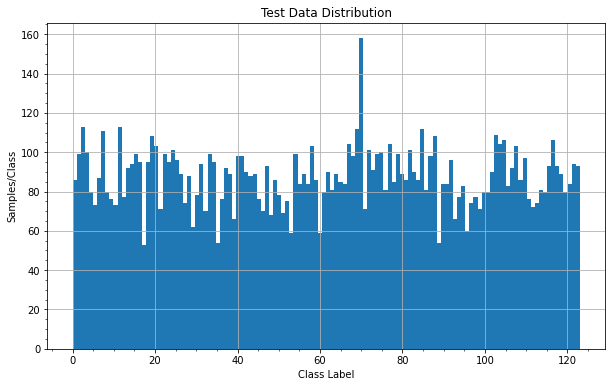

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(y_test,bins=124)
ax.set_xlabel('Class Label')
ax.set_ylabel('Samples/Class',)
ax.set_title('Test Data Distribution')
ax.grid(True)
ax.minorticks_on()

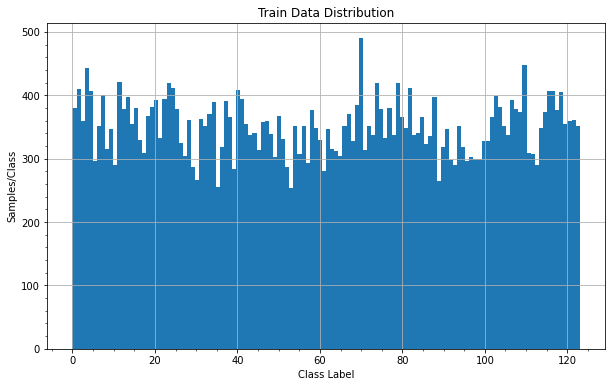

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(y_train,bins=124)
ax.set_xlabel('Class Label')
ax.set_ylabel('Samples/Class',)
ax.set_title('Train Data Distribution')
ax.grid(True)
ax.minorticks_on()